In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load Dataset

In [6]:
def load_crema_data(data_path, max_files=1000):
    """Load CREMA-D dataset with emotion labels"""
    emotions = ['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']
    file_paths = []
    labels = []
    
    for root, _, files in os.walk(data_path):
        for file in files[:max_files]:
            if file.endswith('.wav'):
                emotion_code = file.split('_')[2]
                if emotion_code in emotions:
                    file_paths.append(os.path.join(root, file))
                    labels.append(emotion_code)
    
    # Convert emotion codes to full names
    emotion_map = {'ANG':'angry', 'DIS':'disgust', 'FEA':'fear', 
                   'HAP':'happy', 'NEU':'neutral', 'SAD':'sad'}
    labels = [emotion_map[l] for l in labels]
    
    return file_paths, labels

data_path = "/kaggle/input/speech-emotion-recognition-en/Crema"  
file_paths, labels = load_crema_data(data_path)

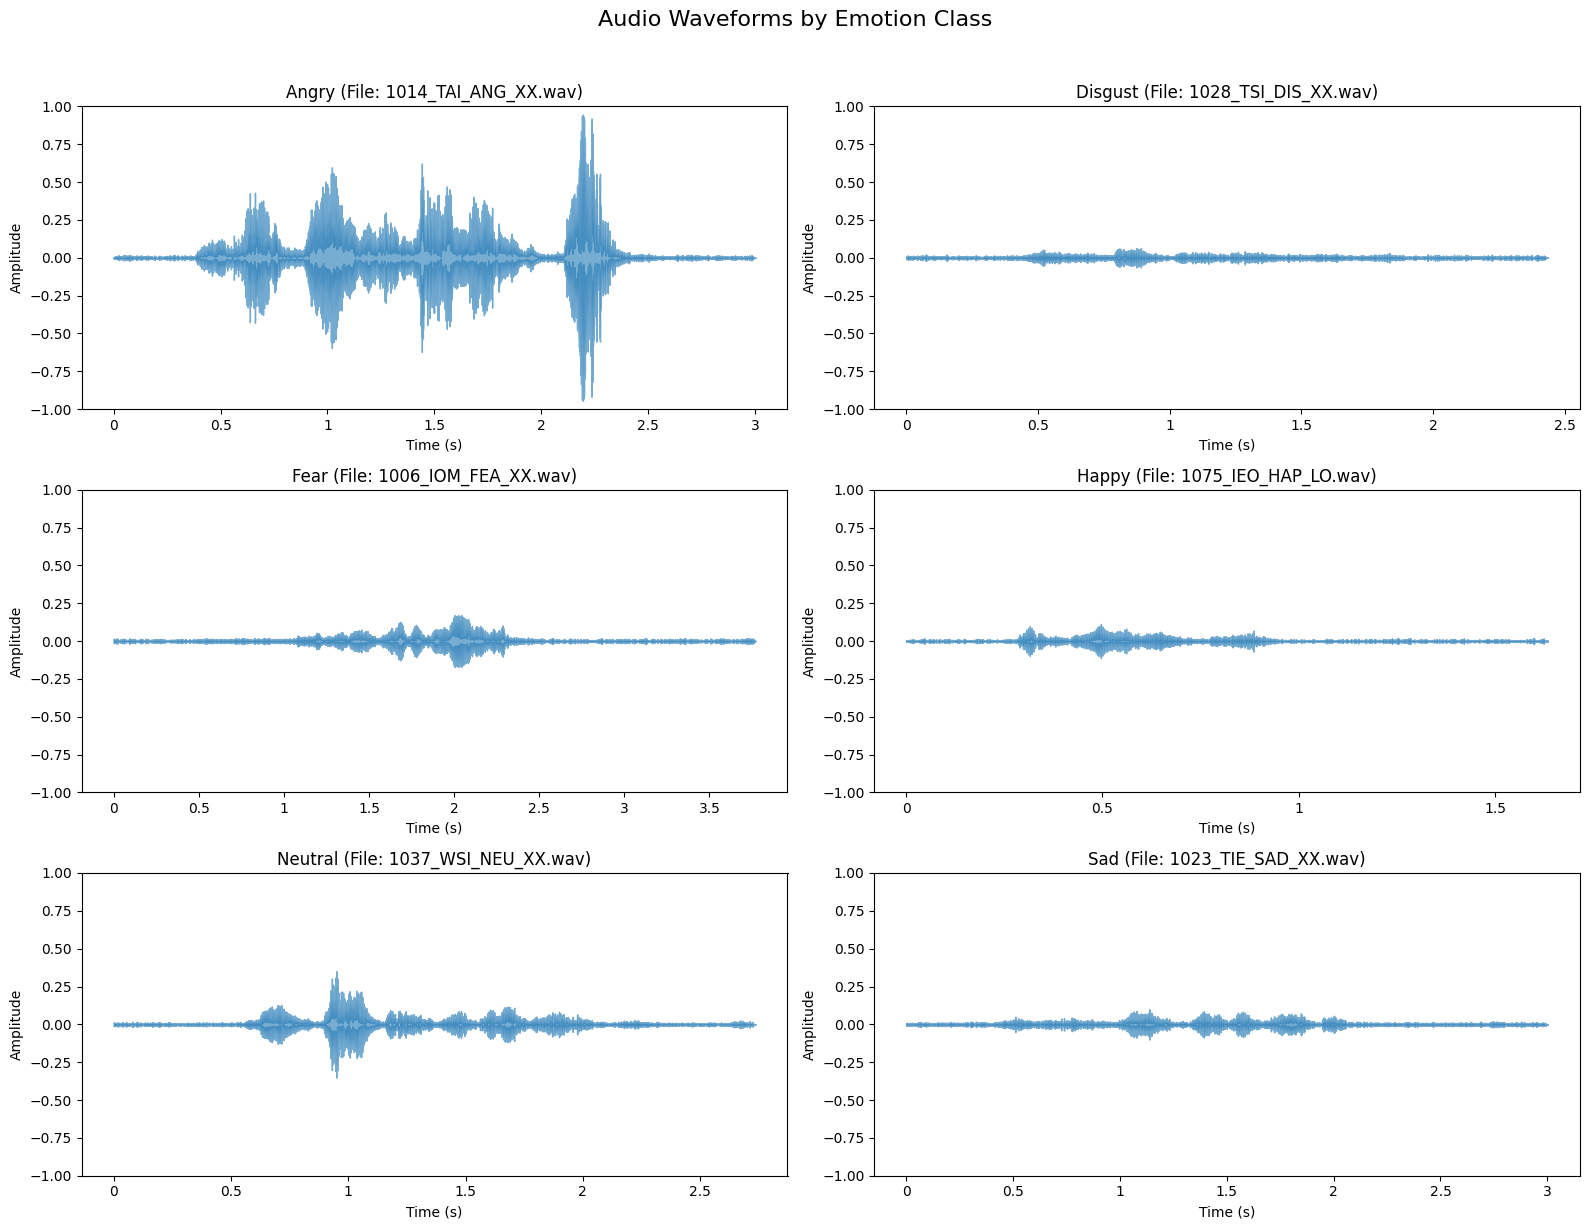

In [18]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display

def explore_emotion_classes(data_path, sample_rate=22050, max_files_per_class=1):
    """
    Load and plot waveform for one sample from each emotion class in CREMA-D dataset
    
    Args:
        data_path: Path to CREMA-D dataset directory
        sample_rate: Target sampling rate (default 22050)
        max_files_per_class: Maximum number of samples to display per emotion
    """
    # CREMA-D emotion codes mapping
    emotion_map = {
        'ANG': 'Angry',
        'DIS': 'Disgust',
        'FEA': 'Fear',
        'HAP': 'Happy',
        'NEU': 'Neutral',
        'SAD': 'Sad'
    }
    
    # Create figure for plots
    plt.figure(figsize=(16, 12))
    plt.suptitle('Audio Waveforms by Emotion Class', y=1.02, fontsize=16)
    
    # Process each emotion class
    for i, (code, emotion) in enumerate(emotion_map.items()):
        # Find first matching file for this emotion
        for root, _, files in os.walk(data_path):
            for file in files:
                if file.endswith('.wav') and code in file:
                    # Load audio file
                    file_path = os.path.join(root, file)
                    y, sr = librosa.load(file_path, sr=sample_rate)
                    
                    # Create subplot
                    plt.subplot(3, 2, i+1)
                    librosa.display.waveshow(y, sr=sr, alpha=0.6)
                    plt.title(f'{emotion} (File: {file})')
                    plt.xlabel('Time (s)')
                    plt.ylabel('Amplitude')
                    plt.ylim(-1, 1)
                    
                    # Play audio in notebook (remove if not using Jupyter)
                    display(Audio(data=y, rate=sr))
                    
                    if max_files_per_class <= 1:
                        break
            else:
                continue
            break
    
    plt.tight_layout()
    plt.show()


explore_emotion_classes(data_path)

# mel spectrogram

In [9]:
def extract_mel_spectrogram(file_path, n_mels=128):
    """Extract log-mel spectrogram features"""
    y, sr = librosa.load(file_path, sr=22050, duration=3.0)
    if len(y) < 66150:  # Pad if shorter than 3s
        y = np.pad(y, (0, 66150 - len(y)), mode='constant')
    
    # Create mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    log_S = librosa.power_to_db(S, ref=np.max)
    
    # Ensure consistent shape (128, 130)
    if log_S.shape[1] < 130:
        log_S = np.pad(log_S, ((0,0), (0,130-log_S.shape[1])), mode='constant')
    else:
        log_S = log_S[:, :130]
    
    return log_S

# Extract mel spectrograms
print("Extracting mel spectrograms...")
features = []
for file_path in file_paths:
    features.append(extract_mel_spectrogram(file_path))

Extracting mel spectrograms...


In [10]:
## CNN Model Architecture
def create_cnn_model(input_shape, num_classes):
    """Create a high-performance CNN model using only conv, pool, and dense layers"""
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # First Conv Block
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),
        
        # Second Conv Block
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),
        
        # Third Conv Block
        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),
        
        # Flatten and Dense Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

In [16]:
X = np.array(features)
y = np.array(labels)
    
print("Shape before adding channel:", X.shape)
# Typical mel-spectrogram shape: (n_samples, 128, 130)

Shape before adding channel: (1000, 128, 130)


2025-05-09 13:37:05.220539: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Training model...
Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 170s 8s/step - accuracy: 0.2708 - loss: 4.1816 - val_accuracy: 0.1619 - val_loss: 203.4534 - learning_rate: 0.0010
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 160s 8s/step - accuracy: 0.3242 - loss: 4.3807 - val_accuracy: 0.1619 - val_loss: 110.1619 - learning_rate: 0.0010
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 206s 9s/step - accuracy: 0.3690 - loss: 4.3418 - val_accuracy: 0.1905 - val_loss: 48.1830 - learning_rate: 0.0010
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 162s 9s/step - accuracy: 0.3917 - loss: 4.1287 - val_accuracy: 0.1714 - val_loss: 22.7069 - learning_rate: 0.0010
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 164s 9s/step - accuracy: 0.4445 - loss: 3.9425 - val_accuracy: 0.2095 - val_loss: 9.6423 - learning_rate: 0.0010
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 165s 9s/step - accuracy: 0.4293 - loss: 4.0422 - val_accuracy: 0.2286 - val_loss: 6.2364 - learning_rate: 0.0010
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 168s 9s/step - accuracy: 

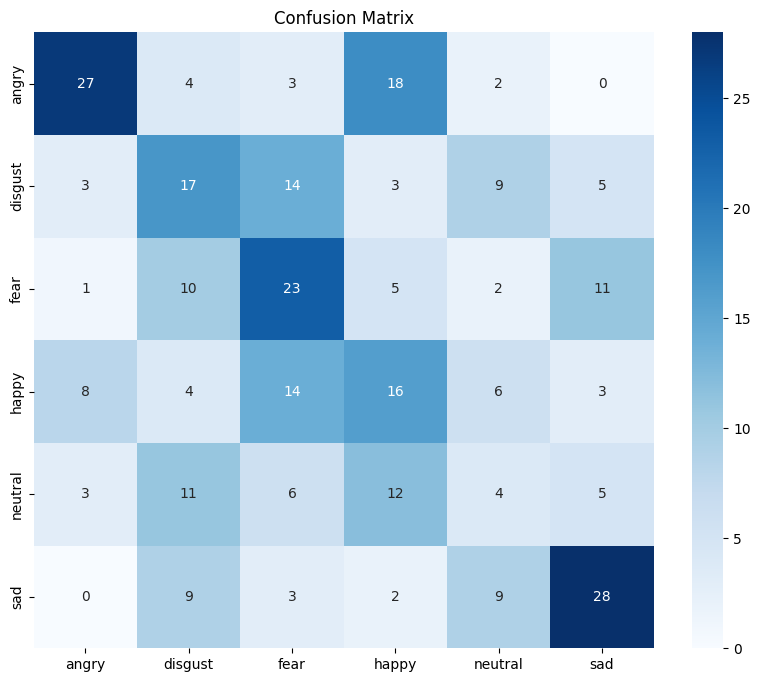

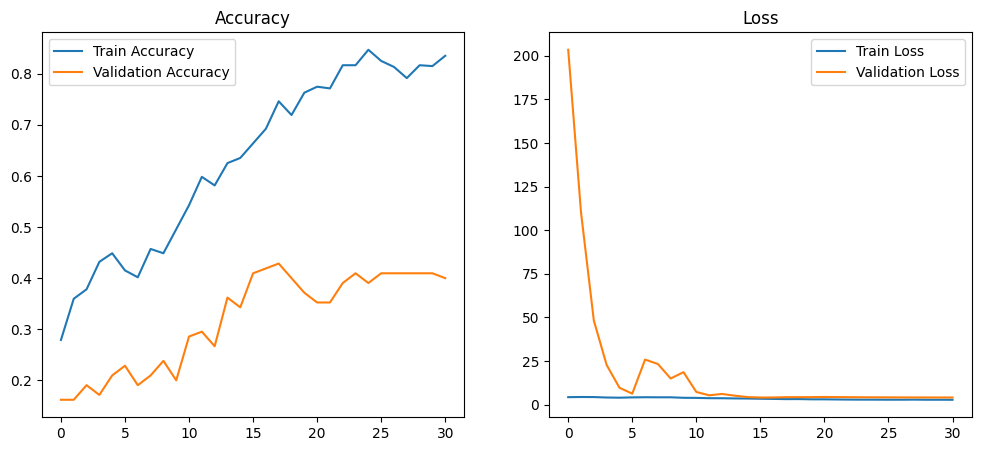

In [17]:

    # Add channel dimension (for CNN)
X = X[..., np.newaxis]  # Shape: (n_samples, 128, 130, 1)
    
    # Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)
    
    # Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
X, y_categorical, test_size=0.3, stratify=y_encoded, random_state=42)
    
    # Create and compile model
model = create_cnn_model(X_train.shape[1:], y_categorical.shape[1])
model.compile(optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                 metrics=['accuracy'])
    
    # Callbacks
callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
]
    
    # Train model
print("Training model...")
history = model.fit(X_train, y_train,
                        validation_split=0.15,
                        epochs=100,
                        batch_size=32,
                        callbacks=callbacks,
                        verbose=1)
    
    # Evaluate
print("Evaluating model...")
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
    
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=le.classes_))
    
    # Confusion Matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.show()
    
    # Plot training history
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
    
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

# do here another parts
